In [1]:
import torch
import torchvision
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

In [2]:
def load_imbalenced_dataset():
    # load dataset
    (_, _), (testX, testY) = mnist.load_data()
    # reshape dataset to have a single channel
    data = torch.load('/kaggle/input/imbalance1000/MNIST_train.pt')
    trainX= []
    trainy = []
    for i in range(len(data)):
        trainX.append(np.array(data[i][0]))
        trainy.append(data[i][1].item())
    trainX = np.array(trainX)
    trainy = np.array(trainy)
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values
    trainY = to_categorical(trainy)
    testY = to_categorical(testY)
    
    return trainX, trainY, testX, testY

In [3]:
# example of loading the generator model and generating images
from math import sqrt
from numpy import asarray
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_class):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = asarray([n_class for _ in range(n_samples)])
    return [z_input, labels]
 
# load model
def add_gen_data(train_data, train_label, model):
    model = load_model(model)
    latent_dim = 100
    n_examples = 5000 # must be a square
    n_class = 0
    # generate images
    latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
    # generate images
    X  = model.predict([latent_points, labels])
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    labels = to_categorical(labels,10)
    train_data_new = np.concatenate((train_data, X))
    train_labels_new = np.concatenate((train_label, labels))
    
    n_class = 9
    latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
    X  = model.predict([latent_points, labels])
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    labels = to_categorical(labels,10)
    train_data_new = np.concatenate((train_data_new, X))
    train_labels_new = np.concatenate((train_labels_new, labels))
    return train_data_new, train_labels_new

In [4]:
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

In [5]:
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
 

In [6]:
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define modelư
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # stores scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

In [7]:
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        plt.subplot(2, 1, 1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        plt.subplot(2, 1, 2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue', label='train')
        plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()

In [8]:
def summarize_performance(scores):
 # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    plt.boxplot(scores)
    plt.show()

In [9]:
def run_test_harness_imbalence():
 # load dataset
    trainX, trainY, testX, testY = load_imbalenced_dataset()
    
    trainX, testX = prep_pixels(trainX, testX)
    # evaluate model
    scores, histories = evaluate_model(trainX, trainY)
    # learning curves
    summarize_diagnostics(histories)
    # summarize estimated performance
    summarize_performance(scores)

In [10]:
def run_test_harness(model):
 # load dataset
    trainX, trainY, testX, testY = load_imbalenced_dataset()
    # prepare pixel data
    trainX_new, trainY_new = add_gen_data(trainX, trainY,model)
    
    trainX_new, testX = prep_pixels(trainX_new, testX)
    # evaluate model
    scores, histories = evaluate_model(trainX_new, trainY_new)
    # learning curves
    summarize_diagnostics(histories)
    # summarize estimated performance
    summarize_performance(scores)

In [11]:
def run_test_harness_imbalence():
 # load dataset
    trainX, trainY, testX, testY = load_imbalenced_dataset()
    
    trainX, testX = prep_pixels(trainX, testX)
    # evaluate model
    scores, histories = evaluate_model(trainX, trainY)
    # learning curves
    summarize_diagnostics(histories)
    # summarize estimated performance
    summarize_performance(scores)

In [12]:
def add_gen_data_dcgan(train_data, train_label):
    model = load_model('/kaggle/input/modeldg-fmnist/generator_0_fm.h5')
    latent_dim = 100
    n_examples = 5000 # must be a square
    n_class = 0
    # generate images
    latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
    # generate images
    X  = model.predict(latent_points)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    labels = to_categorical(labels,10)
    train_data_new = np.concatenate((train_data, X))
    train_labels_new = np.concatenate((train_label, labels))
    
    model = load_model('/kaggle/input/modeldg-fmnist/generator_9_fm.h5')
    n_class = 9
    latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
    X  = model.predict(latent_points)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    labels = to_categorical(labels,10)
    train_data_new = np.concatenate((train_data_new, X))
    train_labels_new = np.concatenate((train_labels_new, labels))
    return train_data_new, train_labels_new
def run_test_harness_dcgan():
 # load dataset
    trainX, trainY, testX, testY = load_imbalenced_dataset()
    # prepare pixel data
    trainX_new, trainY_new = add_gen_data_dcgan(trainX, trainY)
    
    trainX_new, testX = prep_pixels(trainX_new, testX)
    # evaluate model
    scores, histories = evaluate_model(trainX_new, trainY_new)
    # learning curves
    summarize_diagnostics(histories)
    # summarize estimated performance
    summarize_performance(scores)

11501568/11490434 [==============================] - 1s 0us/step
> 98.803
> 98.861
> 99.060
> 98.686
> 98.611


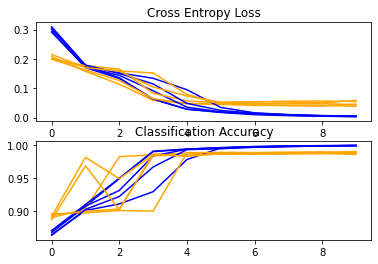

Accuracy: mean=98.804 std=0.155, n=5


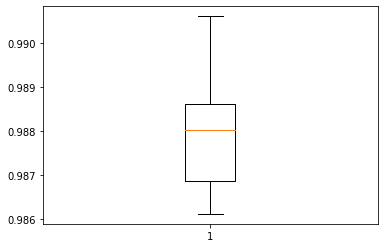

In [14]:
run_test_harness('/kaggle/input/model-cgan/cgan_generator.h5')

In [ ]:
run_test_harness('/kaggle/input/model-acgan2/model_75500.h5')

2022-12-20 18:27:01.563668: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-12-20 18:27:02.032388: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


> 98.786
> 98.803
> 98.836
> 98.736


> 90.762
> 90.570
> 90.537
> 90.678
> 90.362


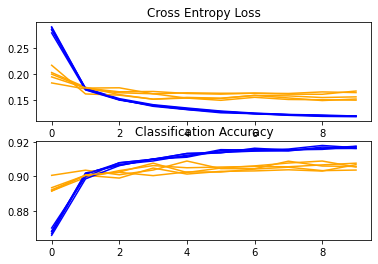

Accuracy: mean=90.582 std=0.136, n=5


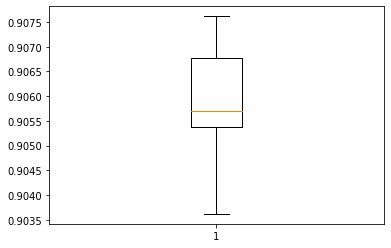

In [18]:
run_test_harness_dcgan()

> 98.713
> 98.654
> 98.723
> 98.584
> 98.733


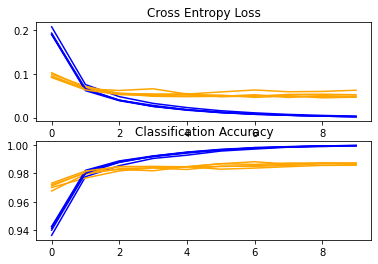

Accuracy: mean=98.681 std=0.056, n=5


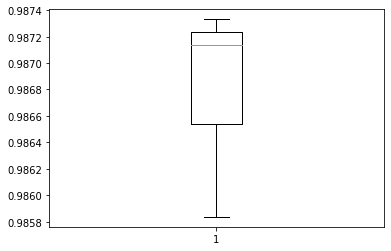

In [109]:
run_test_harness_imbalence()